In [112]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [113]:
prices = pd.concat([pd.read_csv(f'round1/prices_round_1_day_{i}.csv', sep=';') for i in range(-2, 1)], ignore_index=True)
trades = pd.concat([pd.read_csv(f'round1/trades_round_1_day_{i}_nn.csv', sep=';') for i in range(-2, 1)], ignore_index=True)

In [114]:
ink = prices[prices["product"] == "SQUID_INK"].reset_index(drop=True).copy()

In [115]:
return_windows = [1, 2, 5, 10, 15, 20, 30, 50, 100]

for i in return_windows:
    ink[f'past_change{i}'] = ink['mid_price'] / ink['mid_price'].shift(i) - 1
    ink[f'future_change{i}'] = ink['mid_price'].shift(-i) / ink['mid_price'] - 1

In [116]:
ink['past_change1'].describe()

count    29999.000000
mean        -0.000002
std          0.000912
min         -0.053963
25%         -0.000502
50%          0.000000
75%          0.000503
max          0.039301
Name: past_change1, dtype: float64

In [117]:
ink['past_change1'].abs().describe()

count    29999.000000
mean         0.000563
std          0.000717
min          0.000000
25%          0.000250
50%          0.000502
75%          0.000764
max          0.053963
Name: past_change1, dtype: float64

In [118]:
ink.columns
cols = ['timestamp', 'mid_price', 'past_change1', 'future_change1']

In [119]:
top_thresh = 0.002

ink[ink['past_change1'].abs() > top_thresh][cols]

,timestamp,mid_price,past_change1,future_change1
224,22400,1995.5,0.002009,0.000000
514,51400,1981.0,-0.002769,0.002272
515,51500,1985.5,0.002272,-0.000755
800,80000,1995.0,-0.002251,0.000251
1342,134200,1994.5,-0.002002,0.002006
...,...,...,...,...
29942,994200,1851.5,-0.002693,-0.000540
29950,995000,1835.5,-0.004879,-0.001634
29952,995200,1825.5,-0.003820,-0.001643
29960,996000,1836.0,0.002457,0.000272


In [120]:
big_change_idx = 154
forward_lookup_size = 10

ink.loc[big_change_idx:big_change_idx+forward_lookup_size][cols]

,timestamp,mid_price,past_change1,future_change1
154,15400,1997.5,-0.000500,0.000250
155,15500,1998.0,0.000250,0.001251
156,15600,2000.5,0.001251,-0.000750
157,15700,1999.0,-0.000750,0.000250
158,15800,1999.5,0.000250,-0.000500
159,15900,1998.5,-0.000500,-0.000751
160,16000,1997.0,-0.000751,0.000250
161,16100,1997.5,0.000250,-0.000250
162,16200,1997.0,-0.000250,-0.000250
163,16300,1996.5,-0.000250,-0.001002


In [121]:
px.line(ink.loc[big_change_idx:big_change_idx+forward_lookup_size][cols], 'timestamp', 'mid_price')

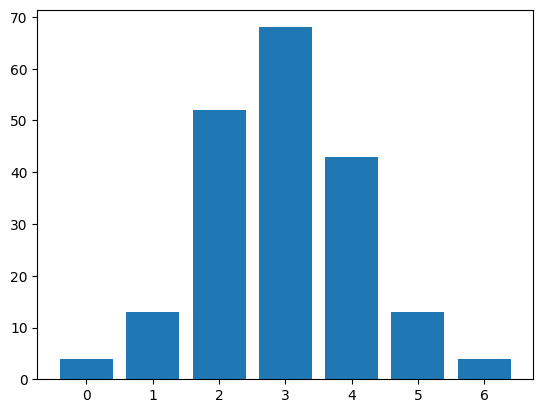

In [122]:
top_thresh = 0.003
forward_lookup_size = 5

num_matches = []

for idx, row in ink[ink['past_change1'].abs() > top_thresh][cols].iterrows():
    big_change_idx = idx

    get_change_direction = lambda x: 1 if x > 0 else -1

    change_direction = get_change_direction(row['past_change1'])

    forward_rows = ink.loc[big_change_idx+1:big_change_idx+forward_lookup_size+1][cols]
    avg_fw_change = forward_rows['past_change1'].mean()
    fw_change_direction = forward_rows['past_change1'].apply(get_change_direction)

    num_matching_direction = (fw_change_direction == change_direction).sum()
    num_matches.append(num_matching_direction)


plt.bar(np.unique_counts(num_matches).values, np.unique_counts(num_matches).counts)
plt.show()

In [123]:
np.unique_counts(num_matches)

UniqueCountsResult(values=array([0, 1, 2, 3, 4, 5, 6]), counts=array([ 4, 13, 52, 68, 43, 13,  4]))

In [126]:
ink['past_change1'].abs().describe()

count    29999.000000
mean         0.000563
std          0.000717
min          0.000000
25%          0.000250
50%          0.000502
75%          0.000764
max          0.053963
Name: past_change1, dtype: float64